In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.util import Surv
import shap
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, classification_report
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score
from sklearn.impute import KNNImputer

In [2]:
random_state = 7
cv_method = StratifiedKFold(n_splits=5)

In [41]:
df = pd.read_csv('../data/surv_optselected_2_8.gz', index_col='id')
df.shape

(4338, 28288)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4338 entries, 3918 to 23911
Columns: 28288 entries, ureacreat_ratio__variance_larger_than_standard_deviation to cat8
dtypes: float64(28267), int64(1), object(20)
memory usage: 936.3+ MB


In [43]:
df['aki_1'].fillna(value=0, inplace=True)
df['aki_2'].fillna(value=0, inplace=True)
df['aki_3'].fillna(value=0, inplace=True)

In [44]:
df.loc[df.gn == 'pign', 'gn'] = 'unspecific'
df.loc[df.gn == 'fgn/itg', 'gn'] = 'unspecific'

In [45]:
df['eskd_begin'] = np.where(df['eskd.y'] <= 0, True, False)
df['eskd_begin'].value_counts()

False    3560
True      778
Name: eskd_begin, dtype: int64

In [46]:
df_rm_eskd_begin = df.query("eskd_begin == False")
df_rm_eskd_begin.shape

(3560, 28289)

In [47]:
df_rm_eskd_begin.drop('eskd_begin', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
df_rm_eskd_begin.head()

,ureacreat_ratio__variance_larger_than_standard_deviation,ureacreat_ratio__has_duplicate_max,ureacreat_ratio__has_duplicate_min,ureacreat_ratio__has_duplicate,ureacreat_ratio__abs_energy,ureacreat_ratio__mean_abs_change,ureacreat_ratio__mean_change,ureacreat_ratio__mean_second_derivative_central,ureacreat_ratio__median,ureacreat_ratio__mean,ureacreat_ratio__standard_deviation,ureacreat_ratio__variation_coefficient,ureacreat_ratio__variance,ureacreat_ratio__skewness,ureacreat_ratio__kurtosis,ureacreat_ratio__root_mean_square,ureacreat_ratio__absolute_sum_of_changes,ureacreat_ratio__longest_strike_below_mean,ureacreat_ratio__longest_strike_above_mean,ureacreat_ratio__count_above_mean,ureacreat_ratio__count_below_mean,ureacreat_ratio__last_location_of_maximum,ureacreat_ratio__first_location_of_maximum,ureacreat_ratio__last_location_of_minimum,ureacreat_ratio__first_location_of_minimum,ureacreat_ratio__percentage_of_reoccurring_values_to_all_values,ureacreat_ratio__percentage_of_reoccurring_datapoints_to_all_datapoints,ureacreat_ratio__sum_of_reoccurring_values,ureacreat_ratio__sum_of_reoccurring_data_points,ureacreat_ratio__ratio_value_number_to_time_series_length,ureacreat_ratio__sample_entropy,ureacreat_ratio__maximum,ureacreat_ratio__minimum,ureacreat_ratio__benford_correlation,ureacreat_ratio__time_reversal_asymmetry_statistic__lag_1,ureacreat_ratio__time_reversal_asymmetry_statistic__lag_2,ureacreat_ratio__time_reversal_asymmetry_statistic__lag_3,ureacreat_ratio__c3__lag_1,ureacreat_ratio__c3__lag_2,ureacreat_ratio__c3__lag_3,...,sta_hr__permutation_entropy__dimension_3__tau_1,sta_hr__permutation_entropy__dimension_4__tau_1,sta_hr__permutation_entropy__dimension_5__tau_1,sta_hr__permutation_entropy__dimension_6__tau_1,sta_hr__permutation_entropy__dimension_7__tau_1,sta_hr__query_similarity_count__query_None__threshold_0.0,"sta_hr__matrix_profile__feature_""""""""""""""""min""""""""""""""""__threshold_0.98","sta_hr__matrix_profile__feature_""""""""""""""""max""""""""""""""""__threshold_0.98","sta_hr__matrix_profile__feature_""""""""""""""""mean""""""""""""""""__threshold_0.98","sta_hr__matrix_profile__feature_""""""""""""""""median""""""""""""""""__threshold_0.98","sta_hr__matrix_profile__feature_""""""""""""""""25""""""""""""""""__threshold_0.98","sta_hr__matrix_profile__feature_""""""""""""""""75""""""""""""""""__threshold_0.98",aki_1,aki_2,aki_3,htn,dkd,gn,gender,value_egfr_init,egfr.y,eskd.y,age.init,death.y,cat0.5,cat1,cat1.5,cat2,cat2.5,cat3,cat3.5,cat4,cat4.5,cat5,cat5.5,cat6,cat6.5,cat7,cat7.5,cat8
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3918,0.0,0.0,0.0,0.0,0.013588,0.004620,-0.004620,-0.000227,0.067347,0.067195,0.003773,0.056155,0.000014,-0.147441,NaN,0.067301,0.009239,1.0,2.0,2.0,1.0,0.333333,0.000000,1.000000,0.666667,0.0,0.0,0.0,0.0,1.0,NaN,0.071739,0.062500,-0.303387,-0.000084,0.000000,0.000000,0.000302,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,htn,dkd,no,Female,52.16,6.255932,NaN,67,NaN,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd
3921,0.0,0.0,0.0,0.0,0.021038,0.020792,0.020792,-0.008116,0.087324,0.081913,0.017402,0.212450,0.000303,-1.068754,NaN,0.083741,0.041584,1.0,2.0,2.0,1.0,1.000000,0.666667,0.333333,0.000000,0.0,0.0,0.0,0.0,1.0,NaN,0.100000,0.058416,0.297356,0.000575,0.000000,0.000000,0.000510,0.000000,0.000000,...,0.693147,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,htn,no,no,Male,90.00,5.785562,NaN,55,NaN,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd,non_eskd
3924,0.0,0.0,0.0,0.0,0.011960,0.015921,0.015921,0.006274,0.057534,0.061717,0.013332,0.216015,0.000178,1.077136,NaN,0.063141,0.031842,2.0,1.0,1.0,2.0,1.000000,0.666667,0.333333,0.000000,0.0,0.0,0.0,0.0,1.0,NaN,0.079730,0.047887,-0.301056,0.000234,0.000000,0.000000,0.0002

In [49]:
df_rm_eskd_begin['status'] = np.where(df_rm_eskd_begin['eskd.y'].isna(), False, True)
df_rm_eskd_begin['duration'] = np.where(df_rm_eskd_begin['eskd.y'].isna(), df_rm_eskd_begin['egfr.y'], df_rm_eskd_begin['eskd.y'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
percent_missing = df_rm_eskd_begin.isnull().sum()*100 / len(df)
missing_df = pd.DataFrame({'column_name': df_rm_eskd_begin.columns, 'percent_miss': percent_missing})
missing_df.sort_values(by='percent_miss', ascending=False)

,column_name,percent_miss
"phosphate__fft_coefficient__attr_""""""""""""""""abs""""""""""""""""__coeff_78","phosphate__fft_coefficient__attr_""""""""""""""""abs""""...",82.065468
"sta_dia__fft_coefficient__attr_""""""""""""""""angle""""""""""""""""__coeff_65","sta_dia__fft_coefficient__attr_""""""""""""""""angle""""...",82.065468
"sta_dia__fft_coefficient__attr_""""""""""""""""angle""""""""""""""""__coeff_55","sta_dia__fft_coefficient__attr_""""""""""""""""angle""""...",82.065468
"sta_dia__fft_coefficient__attr_""""""""""""""""angle""""""""""""""""__coeff_56","sta_dia__fft_coefficient__attr_""""""""""""""""angle""""...",82.065468
"sta_dia__fft_coefficient__attr_""""""""""""""""angle""""""""""""""""__coeff_57","sta_dia__fft_coefficient__attr_""""""""""""""""angle""""...",82.065468
...,...,...
htn,htn,0.000000
aki_3,aki_3,0.000000
aki_2,aki_2,0.000000
aki_1,aki_1,0.000000


In [5]:
def to_category(df):
    cols = df.select_dtypes(include='object').columns
    for col in cols:
        df[col] = df[col].astype('category')
    return df

def drop_missing(df):
    threshold = len(df)*0.6
    df.dropna(axis=1, thresh=threshold, inplace=True)
    return df

def copy_df(df):
    return df.copy()

In [52]:
df_cleaned = (df_rm_eskd_begin.pipe(copy_df).pipe(drop_missing).pipe(to_category))
df_cleaned.shape

(3560, 6056)

In [3]:
df_cleaned = pd.read_csv('../data/cleaned_surv_2_8.gz', index_col='id')
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3560 entries, 3918 to 23864
Columns: 6056 entries, ureacreat_ratio__variance_larger_than_standard_deviation to duration
dtypes: bool(1), float64(6034), int64(1), object(20)
memory usage: 164.5+ MB


In [6]:
df_cleaned = (df_cleaned.pipe(copy_df).pipe(to_category))

In [7]:
df_cleaned['status'].value_counts()

False    2436
True     1124
Name: status, dtype: int64

In [56]:
from sksurv.nonparametric import kaplan_meier_estimator
time, surv_prob = kaplan_meier_estimator(df_cleaned['status'], df_cleaned['duration'])

Text(0.5, 0, 'Time in years')

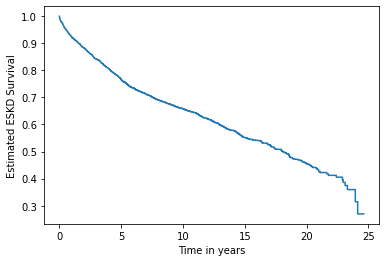

In [58]:
import matplotlib.pyplot as plt
plt.step(time, surv_prob, where='post')
plt.ylabel('Estimated ESKD Survival')
plt.xlabel('Time in years')

In [98]:
percent_missing = df_cleaned.isna().sum()*100 / len(df_cleaned)
missing_df_cleaned = pd.DataFrame({'column_name': df_cleaned.columns, 'percent_miss': percent_missing})
missing_df_cleaned.sort_values(by='percent_miss', ascending=False)

,column_name,percent_miss
egfr__permutation_entropy__dimension_5__tau_1,egfr__permutation_entropy__dimension_5__tau_1,39.634831
"egfr__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)",egfr__cwt_coefficients__coeff_4__w_20__widths_...,39.634831
"egfr__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)",egfr__cwt_coefficients__coeff_4__w_10__widths_...,39.634831
"egfr__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)",egfr__cwt_coefficients__coeff_4__w_5__widths_(...,39.634831
"egfr__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)",egfr__cwt_coefficients__coeff_4__w_2__widths_(...,39.634831
...,...,...
dkd,dkd,0.000000
htn,htn,0.000000
aki_2,aki_2,0.000000
aki_1,aki_1,0.000000


In [8]:
dropped_cols = list(df_cleaned.columns[-20:])
dropped_cols.remove('age.init')
dropped_cols

['egfr.y',
 'cat0.5',
 'cat1',
 'cat1.5',
 'cat2',
 'cat2.5',
 'cat3',
 'cat3.5',
 'cat4',
 'cat4.5',
 'cat5',
 'cat5.5',
 'cat6',
 'cat6.5',
 'cat7',
 'cat7.5',
 'cat8',
 'status',
 'duration']

In [9]:
X = df_cleaned.drop(dropped_cols, axis=1).copy()
y = df_cleaned[['status', 'duration']].copy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y['status'], random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2848, 6037), (712, 6037), (2848, 2), (712, 2))

In [20]:
y_train = Surv.from_dataframe('status', 'duration', y_train)
y_test = Surv.from_dataframe('status', 'duration', y_test)

In [11]:
category_cols = list(X_train.select_dtypes(include='category').columns)
numeric_cols = list(X_train.select_dtypes(include=['int', 'float']).columns)
one_hot = OneHotEncoder(handle_unknown='ignore')
num_imputer = KNNImputer(n_neighbors=5)
len(category_cols), len(numeric_cols)

(4, 6033)

In [12]:
preprocess = ColumnTransformer([('num_imputing', num_imputer, numeric_cols), ('cat_encoder', one_hot, category_cols)], remainder='passthrough')
X_train_processed = preprocess.fit_transform(X_train)
X_train_processed.shape

(2848, 6048)

In [13]:
X_test_processed = preprocess.transform(X_test)

In [19]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=random_state, n_jobs=-1)
rsf.fit(X_train_processed, y_train)

ValueError: y must be a structured array with the first field being a binary class event indicator and the second field the time of the event/censoring

In [15]:
import joblib

In [ ]:
joblib.dump(rsf, 'best_rsf.pkl', compress=1)

In [21]:
rsf = joblib.load('best_rsf.pkl')

In [22]:
rsf.score(X_test_processed, y_test)

0.894881387132211

In [23]:
category_label = list(preprocess.named_transformers_['cat_encoder'].get_feature_names(category_cols))
feature_label = numeric_cols + category_label

In [24]:
len(feature_label)

6048

In [41]:
show_weights(rsf)

In [25]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test_processed, y_test)


NameError: name 'eli5' is not defined

In [40]:
from eli5 import show_weights, explain_weights
feature_weights = show_weights(perm, feature_names = feature_label, top=1000)
feature_weights

Weight,Feature
0.0087 ± 0.0081,egfr__minimum
0.0037 ± 0.0064,egfr__quantile__q_0.7
0.0032 ± 0.0041,egfr__quantile__q_0.2
0.0029 ± 0.0075,egfr__median
0.0028 ± 0.0038,egfr__quantile__q_0.1
0.0025 ± 0.0057,egfr__quantile__q_0.3
0.0024 ± 0.0041,egfr__quantile__q_0.4
0.0023 ± 0.0034,egfr__quantile__q_0.9
0.0020 ± 0.0047,egfr__maximum
0.0016 ± 0.0025,urea__quantile__q_0.8


In [39]:
explain_weights(perm, top=1000)

Weight,Feature
0.0087 ± 0.0081,x1736
0.0037 ± 0.0064,x1790
0.0032 ± 0.0041,x1786
0.0029 ± 0.0075,x1713
0.0028 ± 0.0038,x1785
0.0025 ± 0.0057,x1787
0.0024 ± 0.0041,x1788
0.0023 ± 0.0034,x1792
0.0020 ± 0.0047,x1735
0.0016 ± 0.0025,x3504


In [36]:
feature_weights_df = pd.read_html(feature_weights)
feature_weights_df

ImportError: lxml not found, please install it